In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import datetime

from tqdm import tqdm 
from scipy import stats
from matplotlib.dates import date2num
pd.options.mode.chained_assignment = None

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [2]:
nk_df = pd.read_csv(PATH+'nk_df_v2.csv')
sedol_list = list(nk_df['sedol'])
del nk_df

In [3]:
ret_df = pd.read_pickle(PATH+'checkpoint_data/returns_all_stocks.pkl')
r_df = ret_df[ret_df['sedol'].isin(sedol_list)]
del ret_df

In [5]:
r_df_og = r_df.copy()

In [58]:
r_df_two_day = pd.read_pickle(PATH+'checkpoint_data/ret_two_day.pkl')
r_df_three_day = pd.read_pickle(PATH+'checkpoint_data/ret_three_day.pkl')

In [62]:
date_index_og = sorted(set(r_df['datadate']))

interval_length = 2
two_day_index = [date_index_og[i * interval_length] for i in range(len(date_index_og)//interval_length)]
two_day_df = pd.DataFrame({'two_day_index': two_day_index})

interval_length = 3
three_day_index = [date_index_og[i * interval_length] for i in range(len(date_index_og)//interval_length)]
three_day_df = pd.DataFrame({'three_day_index': three_day_index})

# r_df = pd.merge_asof(r_df.sort_values('datadate'), 
#               two_day_df.sort_values('two_day_index'), 
#               left_on=['datadate'], 
#               right_on=['two_day_index'], 
#               direction='backward')

# r_df = pd.merge_asof(r_df.sort_values('datadate'), 
#               three_day_df.sort_values('three_day_index'), 
#               left_on=['datadate'], 
#               right_on=['three_day_index'], 
#               direction='backward')

# sedol_list = []
# date_list = []
# ret_list = []
# for sedol, sedol_df in tqdm(r_df.groupby('sedol')):
#     for date, date_df in sedol_df.groupby(['two_day_index']):
#         sedol_list.append(sedol)
#         date_list.append(date)
#         ret_list.append(np.exp(np.log((date_df['mod_ret'] + 1)).sum()) - 1)
        
# r_df_two_day = pd.DataFrame({'sedol': sedol_list, 
#                              'date': date_list, 
#                              'two_day_ret': ret_list})

# sedol_list = []
# date_list = []
# ret_list = []
# for sedol, sedol_df in tqdm(r_df.groupby('sedol')):
#     for date, date_df in sedol_df.groupby(['three_day_index']):
#         sedol_list.append(sedol)
#         date_list.append(date)
#         ret_list.append(np.exp(np.log((date_df['mod_ret'] + 1)).sum()) - 1)
        
# r_df_three_day = pd.DataFrame({'sedol': sedol_list, 
#                              'date': date_list, 
#                               'three_day_ret': ret_list})

# r_df_two_day.to_pickle(PATH+'checkpoint_data/ret_two_day.pkl')
# r_df_three_day.to_pickle(PATH+'checkpoint_data/ret_three_day.pkl')

In [94]:
r_df = r_df_og
date_index = date_index_og

In [95]:
r_df_match = r_df.copy()
r_df_match = r_df_match[['datadate', 'mod_ret', 'sedol']]

In [87]:
sedol_list = []
for sedol, sedol_df in tqdm(r_df.groupby('sedol')):
    sedol_df = sedol_df.set_index('datadate').reindex(date_index).reset_index()
    sedol_df['datadate_l1'] = sedol_df['datadate'].shift(1)
    sedol_df = pd.merge(sedol_df, 
                        r_df_match, 
                        left_on=['sedol', 'datadate_l1'], 
                        right_on=['sedol', 'datadate'], 
                        suffixes=[None, '_l1'],
                        how='left').drop(columns=['datadate_l1'])
    sedol_list.append(sedol_df)
r_df = pd.concat(sedol_list)

100%|██████████████████████████████████████████████████████████| 243/243 [01:07<00:00,  3.60it/s]


In [88]:
col_ret_used_for_ranking = 'mod_ret_l1'
date_list = []
counter = 0
for date, date_df in tqdm(r_df.groupby('datadate')):
    if len(date_df[[col_ret_used_for_ranking]].dropna()) > 220:
        r_mt_1 = date_df[col_ret_used_for_ranking].mean()
        const = (-1) * ((1/2) * abs(date_df[col_ret_used_for_ranking] - r_mt_1).sum()) ** (-1)
        date_df['reversal_weight'] = const * (date_df[col_ret_used_for_ranking] - r_mt_1)
        date_list.append(date_df)
        
r_df = pd.concat(date_list)

  1%|▍                                                         | 10/1253 [00:00<00:33, 36.77it/s]

2010-10-01 00:00:00


100%|███████████████████████████████████████████████████████| 1253/1253 [00:07<00:00, 166.85it/s]


In [89]:
r_df['reversal_ret'] = r_df['mod_ret'] * r_df['reversal_weight']
rets_df = r_df.groupby(['datadate']).sum().reset_index()
rets_df['log_reversal_ret'] = np.log((rets_df['reversal_ret'] + 1))
rets_df['cum_ret'] = np.exp(rets_df['log_reversal_ret'].cumsum())

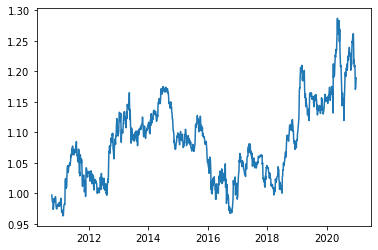

In [97]:
plt.plot(rets_df[rets_df['datadate'] <= pd.to_datetime('2021-01-01')].set_index('datadate')['cum_ret'])